
In this project we implemented a tool to selectively and automatically colorize the foreground of black and white photographs.  The tool consists of two main algorithms.  First,  a GAN network colorizes the entire photograph using transfer learning.  Second, a segmentation network segments the foreground from the background.  Lastly, it blends the  colorized foreground with the original background to produce a distinctive image.

In this notebook the Colorization network is trained and validated.

# Colorization Network

## Approach
For the colorization task we worked on the __Lab__ colorspace.  In this space, the __L__ channel contains the luminance or intensity information, while the __ab__ channels contain the color information.  Therefore, a neural network can be trained with the __L__ channel of regular color images as input. Its predictions will be "fake" __ab__ channels and its loss will be calculated with the "real" __ab__ channels.

After a short bibliographic review we found that although traditional convolutional neural networks (CNNs) could produce results almost indistinguishable from real color photos [@ZhangIE16], _Generative Adversarial Networks_ or GANs [@goodfellow2014] were the most proper approach for this kind of problem.  This network architecture contains two modules, a Generator and a Discriminator.  Both models are trained in paralell.  The objective of the generator is to produce outputs similar enough to the ground truth that can fool the discriminator.  The discriminator's objective is to properly tell the ground truth from the discriminator output.

Since training this kind of networks requires large datasets and computing time, we decided to use pretrained models that have been used for other tasks such as object classification.  We followed a tutorial inspired by the _pix2pix_ paper [@pix2pix] but instead of training a naïve _UNet_ as the generator, it used a _ResNet18_ network as the generator [@colorizationtutorial].  Similar to _pix2pix_ we used a patch discriminator that splits the image in 26 square patches (depending on the image size) and produces a _real_ or _fake_ prediction for each of them.  

In order to try different approaches, we decided to use _Transformers_ in place of the discriminator and the generator.  _Transformers_ are a special architectures of DNN that make extensive use of attention mechanisms [@transformers].  Because of their ability to have larger receptive fields compared to convolutional neural networks (CNNs) that allow tracking long-range dependencies within an image, these attention based architectures have proven very effective in image processing tasks and gave  rise to Visual Transformers or __ViT__ [@ViT].  We tried different architectures with ViTs generators or discriminators and measured a range of metrics for each of them. 

In [ ]:
!pip install fastai 

In [6]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
import cv2
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from torchvision.models import vit_b_16 as visiontransformer
from fastai.vision.models.unet import DynamicUnet
from fastai.data.external import untar_data, URLs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cpu


### Dataset

For training and validation purposes we used a subset of the COCO dataset of images [@cocodataset] that is provided by the FastAI framework [@fastai]. We downloaded 10.000 images from this dataset and randomly splited them into two sets: a training set with 8.000 images and a validation set with 2.000 images.

In [7]:
 coco_path = untar_data(URLs.COCO_SAMPLE)
 coco_path = str(coco_path) + "/train_sample"

8000 2000


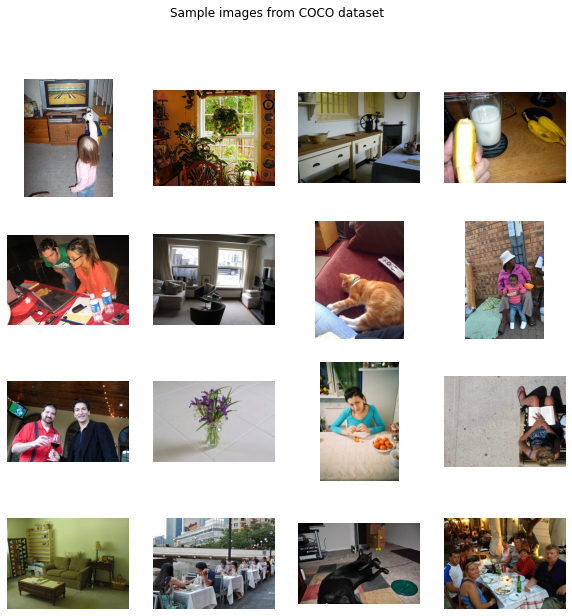

In [8]:
path = coco_path
    
paths = glob.glob(path + "/*.jpg") 
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Sample images from COCO dataset')
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

Then we resized the images so that they have manageable dimensions that allow feeding into the different network architectures without requiring extremely high computational resources or long times.  Similar to [@pix2pix] data augmentation was achieved by flipping the images horizontally (this is only done for the training set).  We used 16 images on each batch that goes through the network.  Each image was converted to the __Lab__ colorspace and the channels adjusted float values between -1 and 1. 

In [9]:
SIZE = 224
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.Resampling.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.Resampling.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    if (os.name=="nt"):
        n_workers = 0  # In Windows, n_workers should be 0
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [11]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

torch.Size([16, 1, 224, 224]) torch.Size([16, 2, 224, 224])


### Loss functions

The loss function of the discriminator for each image is the binary cross entropy between the predictions and the ground truth: _real_ if the real __ab__ channels were fed into the discriminator of _fake_ if the generated __ab__ channels were used instead.  The loss function of the generator was the combination of the L1 error and the loss function of the discriminator as it were _real_ __ab__ channels.  The intuition behind is that the generator "wins" every time it fools the discriminator into assigning _real_ predictions to its outputs. 

In [12]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels) 
        return loss

In [13]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [14]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def model_eval(model, data):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    return fake_imgs, real_imgs
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"output/colorization_{time.time()}.png")
    return fake_imgs, real_imgs
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

## Model Training, Inference and Validation

All the training was done on a machine equipped with an NVIDIA K80 GPU, 4 vCPUs and 61 MB of RAM (_AWS EC2 p2.xlarge_ instance).  The inference, validation and calculation of metrics was done in an Intel i5 CPU with 8 MB of RAM.

For validation we used 2000 images from the __COCO__ dataset that were not used for training, and a set of 70 photographs that were taken by the authors.

To assess the different networks architectures we selected a set of metrics for regression models:

* Correlation coeficient _R_ squared
* Explained variance
* Mean absolute error
* Median absolute error
* Mean squared error

We calculated all these metrics for each one of the __ab__ channels.

In [15]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, net_D=None, use_ViT_gen = False, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.use_ViT_gen = use_ViT_gen
        
        if net_G is None:
            raise NotImplementedError
        else:
            self.net_G = net_G.to(self.device)
        
        if net_D is None:
            self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        else:
            self.net_D = net_D.to(self.device)
            
        #self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)  # Original BCE Loss
        self.GANcriterion = GANLoss(gan_mode='lsgan').to(self.device)  # Final improvement with Least Square Error loss
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        if (self.use_ViT_gen == True):
            outputs = self.net_G(self.L.repeat(1,3,1,1))  # Copy the L channel 3 times to mimick the 3-channels input that the pretrained network requires.
            self.fake_color = outputs.logits
        else:
            self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
        
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [16]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [17]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L.repeat(1,3,1,1))
            preds = preds.logits
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")
        #torch.save(net_G.state_dict(), 'models/net_G_resnet18_model-' + str(e) +'.pt')

In [18]:
def train_model(model, train_dl, epochs, display_every=200, first_epoch=0):
    data_val = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals
    for e in range(first_epoch, epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data_val, save=False) # function displaying the model's outputs
        torch.save(model.state_dict(), 'models/model6-3channel-ViT.pt')



In [19]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error
import pandas as pd

def get_metrics(model, dl):
    test_iter = iter(dl)
    [fa,fb,ra,rb] = [np.zeros((1,SIZE**2))] * 4

    for data in tqdm(test_iter):
        fake_imgs, real_imgs = model_eval(model, data)
        fab = np.reshape(fake_imgs[:,...,1],(fake_imgs.shape[0],-1))
        rab = np.reshape(real_imgs[:,...,1],(real_imgs.shape[0],-1))
        fbb = np.reshape(fake_imgs[:,...,2],(fake_imgs.shape[0],-1))
        rbb = np.reshape(real_imgs[:,...,2],(real_imgs.shape[0],-1))
        fa = np.concatenate((fa,fab))
        fb = np.concatenate((fb,fbb))
        ra = np.concatenate((ra,rab))
        rb = np.concatenate((rb,rbb))

    table=[]
    table.append(["R-square", r2_score(fa, ra), r2_score(fb, rb)])
    table.append(["Explained variance", explained_variance_score(fa, ra), explained_variance_score(fb, rb)])
    table.append(["Mean absolute error", mean_absolute_error(fa, ra), mean_absolute_error(fb, rb)])
    table.append(["Median absolute error", median_absolute_error(fa, ra), median_absolute_error(fb, rb)])
    table.append(["Mean squared error", mean_squared_error(fa, ra), mean_squared_error(fb, rb)])
    table.append(["Sample size", fa.shape[0], fb.shape[0]])

    df = pd.DataFrame(np.array(table),columns = ['Metric','a-channel','b-channel'])
    return df


### First approach: _ResNet18_ generator


One of the challenges of GANs is that, at the beginning of the training, the task of the discriminator is much easier than that of the generator because the generated outputs are very different from the real ones.  In this situation, the discriminator learns so much faster and gives no time to the generator to adapt.  To avoid this, we gave the generator a _head start_ by training it alone (without the generator) for 20 epochs with a L1 loss function and saving its weights.

In [20]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
# Pretraining of ResNet18 Generator

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20)
torch.save(net_G.state_dict(), "models/net_G_resnet18_model-19.pt")

After that we started the parallel training of the generator and the patch discriminator for another 20 epochs.

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("models/net_G_resnet18_model-19.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)
torch.save(model.state_dict(), "models/colorization2-epoch20.pt")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=224)
model = MainModel(net_G = net_G)
model.load_state_dict(torch.load("models/colorization2-epoch20.pt", map_location=device))

In [ ]:
my_paths = glob.glob("images/*.JPG")
my_dl = make_dataloaders(paths=my_paths, split='val',  n_workers=0) 
my_iter = iter(my_dl)

In [ ]:
data = next(my_iter)
fake_imgs, real_imgs = visualize(model, data, False)

![Results of using a ResNet18 network as the generator.](results/ResNet18.png)

In [ ]:
df = get_metrics(model, val_dl)

In [ ]:
df.to_latex(caption=("ResNet18 metrics on validation dataset","Metrics of ResNet18 generator on validation dataset"))

In [ ]:
df.to_pickle('results/ResNet18onValidation.pkl')

The results of the model with the ResNet18 generator are acceptable.  However, many times they do not look natural because of an excessive use of colors by the generator that resulted in colorful blotches in the pictures.

In agreement with the visual inspection, the resulting metrics on the validation dataset showed that the network did a pretty good job at predicting the __a__-channel with over 97% of the variance of the channel predicted by the model with a very low mean squared error.  However, the prediction on the __b__-channel was not as good with the model predicting only 80% of its variance.

### Second approach: ViT as discriminator

Since the results obtained from the UNet generator did not look quite natural, our first intention was to improve the discriminator so that it will be better at telling apart the _real_ from the _fake_ images.
To do that we decided to replace the CNN based Patch Discriminator with a Visual Transformer.

In [21]:
# Visual Transformer as a descriminator
def build_visiontransformer(n_output=900, size=256):
    net_d = visiontransformer(image_size=size)
    net_d.heads = nn.Linear(768, n_output)
    torch.nn.init.xavier_uniform(net_d.heads.weight)
    return net_d

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("models/net_G_resnet18_model-19.pt", map_location=device))
net_D = build_visiontransformer()
model = MainModel(net_G=net_G, net_D=net_D)
train_model(model, train_dl, 20)
torch.save(net_G.state_dict(), "models/colorization3-epoch20.pt")

![Results of using a ViT as the discriminator network](results/ViTasDiscriminator.png)

Unfortunately, the results were not satisfactory.  The discriminator got very good a discriminating real from fake very early on and gave not chance for the generator to adapt.  The final results are just gray images or sepia looking images with almost no color.  This is because the best loss the generator could achieve was by producing an average value on the __ab__ channels disregarding of the inputs.

### Third approach: Naïve ViT as generator

Once we understood that to have an truly creative network we should put our efforts on the generator instead of on the discriminator, we decided to include a ViT as the generator.

After exploring different options we selected a ViT trained in the task of completing masked images [@Zhenda2021]. We replaced the decoder block of this model by one Convolution layer and a Pixel shuffle layer.  The convolution converted the 14x14x768 inputs into 14x14x512 outputs.  The Pixel shuffle layer with an upscale factor of 16 reshaped those outputs into the final 224x224x2 output that we expected.

In order to avoid the problem of the discriminator learning too fast, we kept the pretraining step with the generator alone to give a _head start_ to it.

In [22]:
# Build transformer based generator
# https://huggingface.co/docs/transformers/model_doc/vit

from transformers import ViTForMaskedImageModeling, ViTConfig


def build_VTi_generator():
    ## First version. Naive generator ViT, 1-input channel.
#    config = ViTConfig(num_channels=1)
#    model = ViTForMaskedImageModeling(config)
#    model.decoder = nn.Sequential(nn.Conv2d(768, 512, kernel_size=(1, 1), stride=(1, 1)), nn.PixelShuffle(upscale_factor=16)) 

    ## Second version. Pretrained generator ViT, 3-input channel, more complex decoder.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTForMaskedImageModeling.from_pretrained("google/vit-base-patch16-224-in21k")

    model.decoder = nn.Sequential(nn.Conv2d(768, 768, kernel_size=3, stride=1, padding=1), \
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(768, 768, kernel_size=3, stride=1, padding=1), \
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(768, 512, kernel_size=3, stride=1, padding=1), \
                                    nn.PixelShuffle(upscale_factor=16))
    model = model.to(device)
    return model


In [ ]:
net_G = build_VTi_generator()
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20)
net_G.load_state_dict(torch.load("models/net_G_ViT-20-pretraining.pt", map_location=device))
model = MainModel(net_G = net_G, use_ViT_gen=True)
train_model(model, train_dl, 20)  # 50 epochs in the naive model
#torch.save(net_G.state_dict(), "models/colorization4-1channel-ViT-epoch20.pt")
torch.save(net_G.state_dict(), "models/colorization6-ViT-epoch20.pt")

Our initial intent was to configure this model to receive a single channel, the __L__ channel, as input.  Since the pretrained models used full 3-channel images as inputs, we decided to start with a __naïve__ model and train it for 50 epochs from scratch using our dataset. 
We were encouraged with the results that showed that the generator was producing color images instead of gray or sepia ones.  However, the colors were timid and blotchy and the produced images were not natural at all.

![Results of using a naïve 1-input channel ViT as the generator network](results/Naive1channelViT.png)

We reasoned that the colorization task requires an underlying knowledge of how natural images look like. Our small dataset and training time was not good enough for the model to capture this knowledge.  Therefore, we decided to switch to a pre-trained model that received 3-channels as inputs.  To mimick that, we just copy the __L__ channel to each of the input channels.

We also realized that the colors produced by the network were distributed in patches that more or less corresponded to the 14x14 outputs of the encoder block of the Transformer.  We supposed that the model was lacking in the expressivity ability of its decoder.  To avoid this problem, we build a more complex decoder block that had 3 convolution layers and activation functions before reaching the final Pixel Shuffle layer.  We trained for 20 epochs.

![Results of task pretraining using a 3-input channels ViT as the generator network with a 3 layers decoder block](results/Pretrained3channelViT_task_pretraining_result.png)

![Results of a 3-input channels ViT as the generator network after training](results/Pretrained3channelViT_task_pretraining_FINAL_result.png)

The results were not very encouraging.  After the task pretraining, when the generator trained alone, the results were acceptable although the colors were not very bright or varied.  However, when we trained with the discriminator, again, the discriminator won the game and the generator produced just gray images, as before.

The other main challenge of training a GAN is choosing the right loss function.  During training of regular networks a convergence of the loss function to a small enough value signals that the network has achieved an equilibrium and cannot learn more from the training data.  However, training of a GAN is a two players game in which each one tries to minimize its own loss by maximizing the other player loss.  The generator and discriminator losses should not converge but stay in a permanent unstable equilibrium which signals that the game is still being played.  

The loss function is what gives the gradient the generator needs to learn to fool the discriminator and not all loss functions are equal for this task.  As already mentioned, at the beginning of the training it is very easy for the discriminator to tell fake from real.  When Cross Entropy is used, it can provide very low or vanishing gradients at the start of the training that do not help the improvement of the generator.  To overcome this problem, it has been suggested the use of least squared errors loss functions [@LSGAN]. Therefore, we replaced the BCE loss with least square errors loss to construct a __LSGAN__.

![Results of a 3-input channel ViT and LSE loss function](results/FINAL_ViT_generator.png)

In [24]:
net_G = build_VTi_generator()
model = MainModel(net_G = net_G, use_ViT_gen=True)
net_G.load_state_dict(torch.load("models/colorization6-ViT-epoch20.pt", map_location=device))
test_paths = glob.glob("images/*.JPG")

my_dl = make_dataloaders(paths=test_paths, split='val',  n_workers=0)  ## n_workers=0 in Windows


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForMaskedImageModeling: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForMaskedImageModeling from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForMaskedImageModeling from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForMaskedImageModeling were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['decoder.0.bias', 'decoder.0.weight', 'embeddings.mask_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model initialized with norm initialization


In [ ]:
data = next(my_iter)
fake_imgs, real_imgs = visualize(model, data, False)

In [ ]:
df = get_metrics(model, val_dl)

In [ ]:
df.to_latex(caption=("ViT metrics on validation dataset","Metrics of ViT generator on validation dataset"))

In [ ]:
df.to_pickle('results/ViTonValidation.pkl')

In [3]:
df = pd.read_pickle('results/ViTonValidation.pkl')

The metrics from LSGAN model were very encouraging.  By using visual transformers we got an improvement over the initial UNet based model on every metric in particular in the __b__-channel which was the most difficult to predict.  For example, this model was able to explain 98% of the variance of the __a__-channel and 86% of the variance of the __b__-channel, against 97% and 80%, respectively, when using the UNet model.

In [26]:
test_iter = iter(val_dl)

c:\users\fnoya\appdata\local\programs\python\python37\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return func(*args, **kwargs)


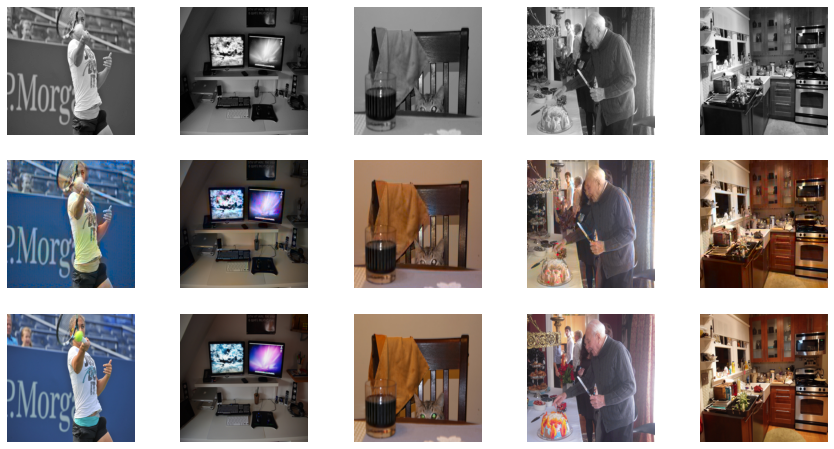

In [28]:
data = next(test_iter)
fake_imgs, real_imgs = visualize(model, data, False)

### Image Upscaling

The LSGAN was trained with 224 by 224 images, so it is better to use downsampled images for inference.  To colorize the full size image, we upscaled the outputs of the network by resizing the predicted __ab__ channels to the size of the original __L__ channel, and combined the results with the __L__ channel to produce a color image in the __Lab__ colorspace.

In [29]:
def write_image(image:np.ndarray, image_path: str):
    '''
    Writes image from image path
    Args:
        image: RGB image of shape H x W x C, with float32 data
        image_path: path to image

    Returns:
        RGB image of shape H x W x 3 in floating point format
    '''
    # read image and convert to RGB
    bgr_image = (image[:, :, [2, 1, 0]] ).astype(np.uint8)
    cv2.imwrite(image_path, bgr_image)

In [32]:
def rescale_img_with_colors (grayscale, pred):
    
    h,w = grayscale.shape
    f = cv2.resize(pred, (w,h))
    f = cv2.cvtColor(f, cv2.COLOR_RGB2LAB)
    L = np.abs(grayscale*100./255.).astype('uint8')  # L channel is in the [0..100]
    new  = np.stack((L, f[...,1], f[...,2]), axis=-1)
    new = cv2.cvtColor(new, cv2.COLOR_LAB2RGB) * 255.
    return new.astype('uint8')
    

### Final colorization results

We tested our LSGAN with historic black and white urban pictures as well as with historic portraits.

We noticed that sometimes old photographs are saturated, particularly, in the sky area.  This causes the LSGAN to interpret them as cloudy skies and producing a white sky.  This effect can be partially overcome by adjusting the gain of the original photo before feeding it into the network.

In [61]:
def show_results(title, images):
    fig, axes = plt.subplots(len(images)//2, 4, figsize=(20,15))
    fig.suptitle(title)
    for (i, [original, color]) in enumerate(images):
        axes[i//2,0+ i % 2 * 2].imshow(original, cmap='gray')
        axes[i//2,0+ i % 2 * 2].axis("off")
        axes[i//2,1+ i % 2 * 2 ].imshow(color)
        axes[i//2,1+ i % 2 * 2].axis("off")
    plt.show()

In [64]:
def colorize_folder(files_paths, save=False):
    test_paths = glob.glob(files_paths)
    my_dl = make_dataloaders(paths=test_paths, split='val',  n_workers=0) 
    my_iter = iter(my_dl)
    i = 0
    images = []
    for data in tqdm(my_iter):
        fake_imgs, real_imgs = model_eval(model, data)
        for fimg in fake_imgs:
            imagefn = test_paths[i]
            i += 1
            original = cv2.imread(imagefn, cv2.IMREAD_GRAYSCALE)
            color = rescale_img_with_colors(original, fimg)
            if save:
                write_image(color, "results/"+imagefn)
            images.append([original, color])
    return images

In [71]:
portraits = colorize_folder("portraits/*.JPG")
urban = colorize_folder("oldimages/*.jpg")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

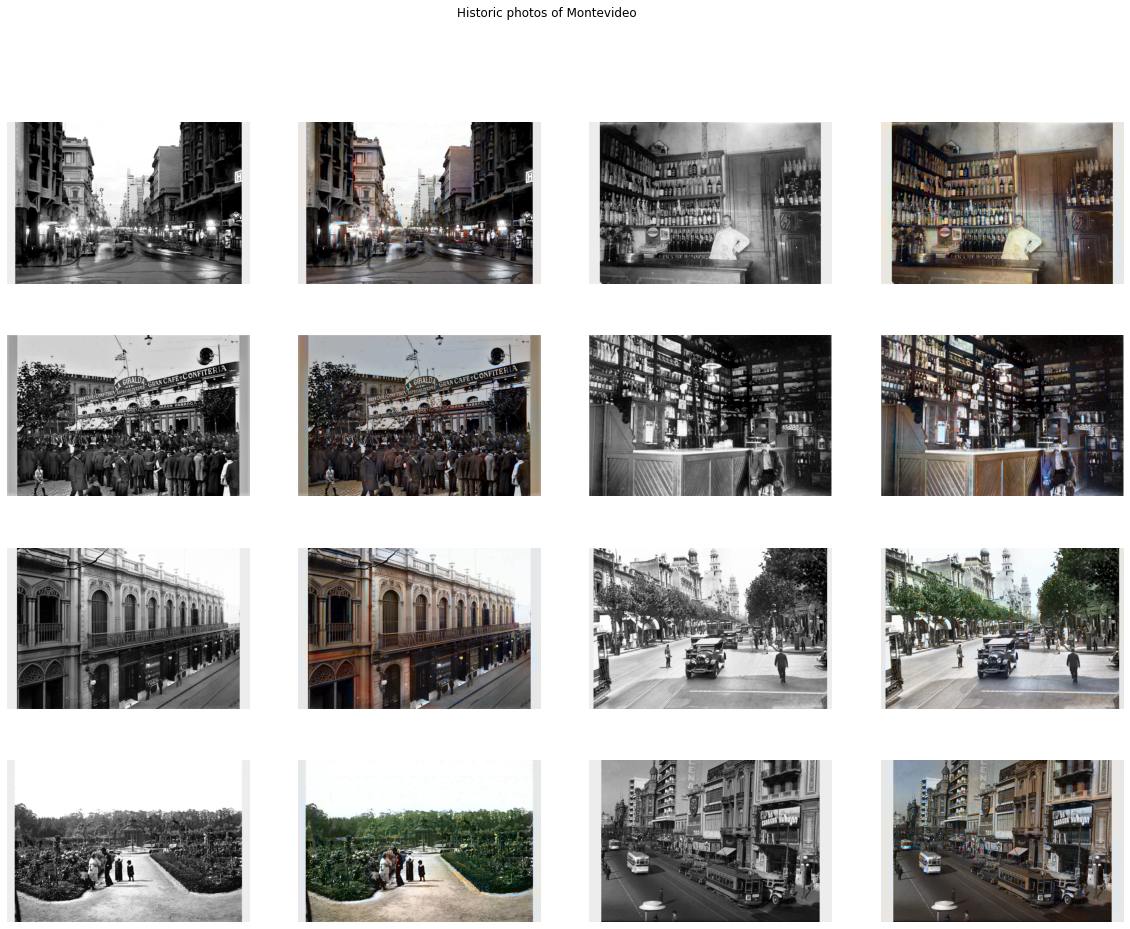

In [72]:
show_results('Historic photos of Montevideo', urban)

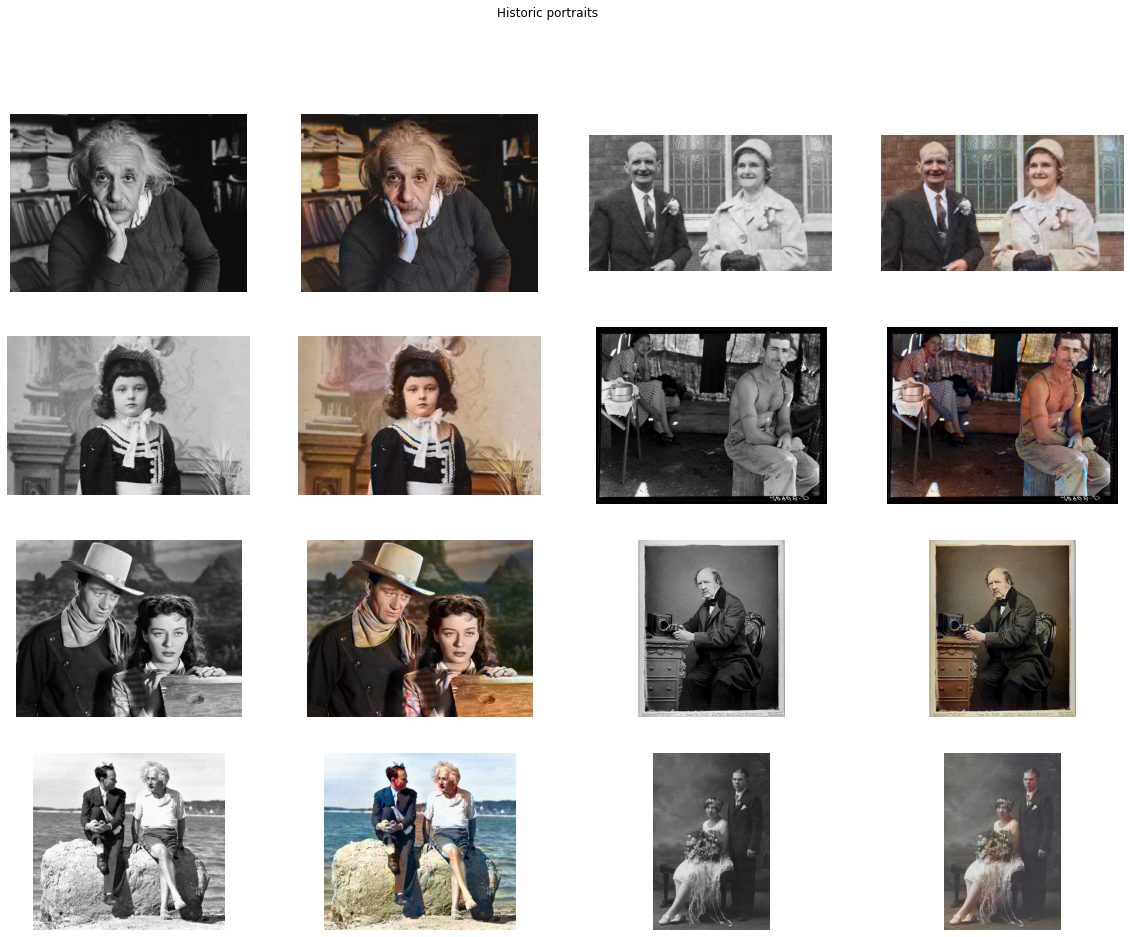

In [73]:
show_results('Historic portraits', portraits)

## Grabcut sandbox

In [ ]:
%matplotlib notebook
#%matplotlib widget

mask_coords = utils.specify_mask(img)
%matplotlib inline 

In [ ]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
fg_mask = utils.get_mask(ys, xs, img)

In [ ]:
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
fg_mask[fg_mask==1] = cv2.GC_PR_FGD
img = np.uint8(img*255)
fg_mask = np.uint8(fg_mask)
(mask, bgModel, fgModel) = cv2.grabCut(img, fg_mask, None, bgModel, \
                                       fgModel, iterCount=5, mode=cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
fg_img = img*mask[:,:,np.newaxis]
plt.imshow(fg_img),plt.colorbar(),plt.show()

In [ ]:
img_gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB) 
mask = mask[:,:,np.newaxis]
final_img = img_gray * (1 - mask) + fg_img * mask
plt.imshow(final_img),plt.show()

 ## References
 
 * https://pyimagesearch.com/2020/07/27/opencv-grabcut-foreground-segmentation-and-extraction/
 * https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html
 * https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8
 * https://doi.org/10.48550/arXiv.2106.06321
 * https://machinelearningmastery.com/generative-adversarial-network-loss-functions/
 * https://arxiv.org/abs/1711.10337   Are GANs Created Equal? A Large-Scale Study, 2018.
 * https://arxiv.org/abs/1406.2661  Generative Adversarial Networks
 * https://arxiv.org/pdf/1704.00028.pdf Improved Training of Wasserstein GANs
 * https://arxiv.org/abs/1611.04076 Least Squares Generative Adversarial Networks
